In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from functools import partial
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as dist
import pyro
import pyro.distributions as pyro_dist
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean, AutoNormal
from pyro.infer import SVI, Trace_ELBO

import bayesreg_pyro as br
import vi_diagnostics as vid

In [12]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()

y_data = torch.Tensor(data["Bodyfat"].values)
x_data = torch.Tensor(data.drop("Bodyfat", axis=1).values)
in_features = x_data.shape[1]

In [92]:
model = br.BayesianRegression(in_features, 1)
guide = AutoDiagonalNormal(model) # Stochastic Mean field
adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

torch.manual_seed(12)
pyro.clear_param_store()
tic=time.time()
elbos, samples = br.run_vi(x_data, y_data, svi, model, guide)
toc=time.time()
print(f"SVI time: {toc-tic} sec")

SVI time: 23.294769763946533 sec


In [50]:
# I think we can use much less samples as optimiser is already in a "good region"?
inf_engine = partial(
    br.run_vi, vi_engine=svi, model=model, guide=guide, num_iterations=5000, return_elbo=False
)
torch.manual_seed(1212)
tic = time.time()
prob = vid.diagnose_vi_VSBC(x_data, model, guide, inf_engine, replications=150)
toc = time.time()


In [71]:
print(f"150 replications took {toc-tic}sec")

150 replications took 1764.602984905243sec


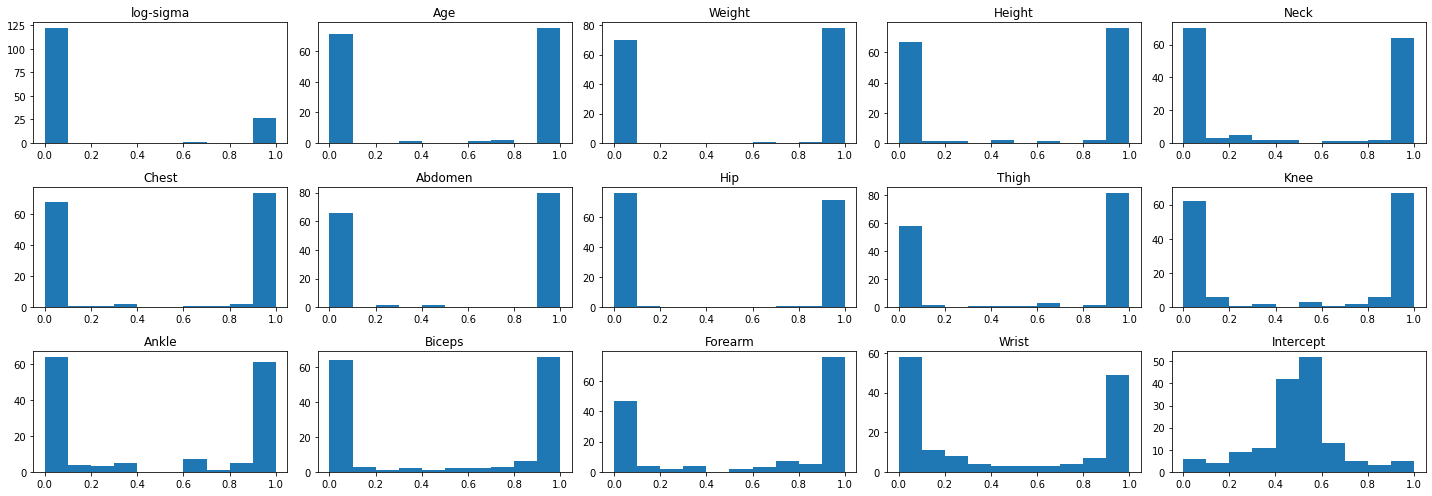

In [85]:
df=pd.DataFrame(prob)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 7))
colnames = ["log-sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]

for i, ax in enumerate(axes.reshape(-1)):
    col = df.columns[i]
    ax.hist(df[col])
    ax.set_title(colnames[i])

plt.tight_layout()
plt.show()

In [73]:
# need to run the same for the mvt model:
torch.manual_seed(12)
pyro.clear_param_store()

guide_mvt = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
svi_mvt = SVI(model, guide_mvt, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

tic = time.time()
elbos_mvt, samples_mvt = br.run_vi(x_data, y_data, svi_mvt, model, guide_mvt)
toc=time.time()
print(f"Non-MFVI time: {toc-tic} sec")

Non-MFVI time: 23.26911187171936 sec


In [82]:
inf_engine_mvt = partial(
    br.run_vi, vi_engine=svi_mvt, model=model, guide=guide_mvt, num_iterations=5000, return_elbo=False
)
torch.manual_seed(1212)
tic = time.time()
prob_mvt = vid.diagnose_vi_VSBC(x_data, model, guide_mvt, inf_engine_mvt, replications=150)
toc = time.time()


...............

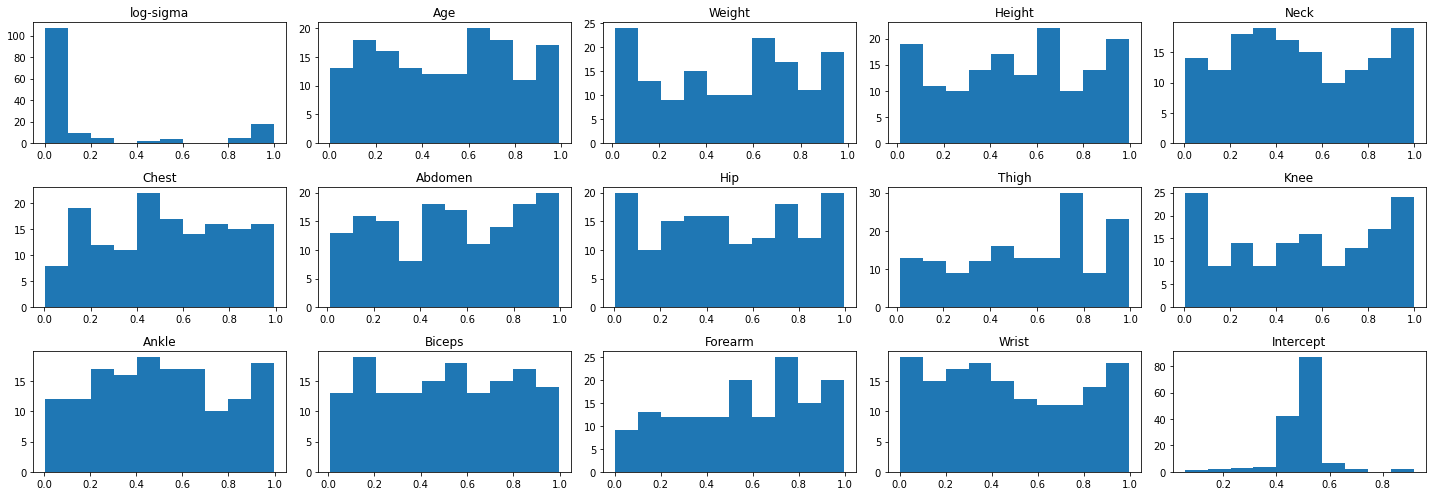

In [88]:
df=pd.DataFrame(prob_mvt)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 7))
colnames = ["log-sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]

for i, ax in enumerate(axes.reshape(-1)):
    col = df.columns[i]
    ax.hist(df[col], bins=10)
    ax.set_title(colnames[i])

plt.tight_layout()
plt.show()

In [84]:
pd.DataFrame(prob).to_csv("prob_MFVI.csv")
pd.DataFrame(prob_mvt).to_csv("prob_MVG_VI.csv")